## Importing Required Libraries

In this section, we import the necessary libraries for data handling, model training, feature selection, and evaluation.

In [1]:
import json
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, Parallel, delayed
from xgboost import XGBClassifier  # XGBoost classifier
from sklearn.metrics import (
    ConfusionMatrixDisplay, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    accuracy_score
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import seaborn as sns
import warnings  # Import the warnings module
from matplotlib import cm

## Setup and Define Model Parameters

Here we define input parameters such as file paths, hyperparameters, and directories for saving results.

In [2]:
# INPUT DATA
dataset_name = 'SB25r'
reduction_method = '_n0.2_process_filt'
# INPUT PARAMETERS
dataset_fraction = 1
# Secondary Parameters
columns_selected = 5
# CPUs

# File Paths
base_path = 'InputModel'
model_basepath = 'Models'

# Create folders if necessary
for path in [model_basepath]:
    if not os.path.exists(path):
        os.makedirs(path)

## Loading and Preprocessing the Dataset

In this step, we load the dataset, apply basic feature engineering (e.g., calculating cyclical week values and vegetation growth rates), and map numerical crop labels to their respective names.

In [3]:
# Start total timing
total_start_time = time.time()

In [4]:
# Load dataset
output_file = os.path.join(base_path, f'{dataset_name}{reduction_method}.csv')
df = pd.read_csv(output_file)
df = df.sample(frac=dataset_fraction, random_state=1)

In [5]:
type_num = df[['Crop_type', 'Crop_num']].drop_duplicates()
print(type_num.sort_values(by='Crop_num'))

        Crop_type  Crop_num
3439        Maize         0
8075          Soy         1
10815   Sunflower         2
13176       Wheat         3
14364      Lucern         4
14998     Pasture         5
20712        Tree         6
24220      Fallow         7
24760  Groundnuts         8
25094     Sorghum         9


In [6]:
# Define remapping
crop_group_map = {
    'Maize': ('Maize', 0),
    'Soy': ('Soy', 1),
    'Sunflower': ('Sunflower', 2),
    'Wheat': ('Wheat', 3),
    'Groundnuts': ('Groundnuts', 4),
    'Sorghum': ('Sorghum', 5),
    'Lucern': ('Other', 6),
    'Pasture': ('Other', 6),
    'Tree': ('Other', 6),
    'Fallow': ('Other', 6)
}

# Apply mapping to full dataset
df_group = df.copy()
df_group[['Crop_type', 'Crop_num']] = df_group['Crop_type'].map(crop_group_map).apply(pd.Series)



In [7]:
# print column names
print(df_group.columns)
print(f"Data shape: {df_group.shape}")


Index(['FIELDID', 'Crop_type', 'Crop_num', 'area_ha', 'Year', 'week',
       'chirps_mean_prec', 'chirps_sum_prec', 'chirps_max_prec',
       'chirps_min_prec', 'chirps_std_prec', 'chirps_cnt_prec', 'era5_temp2m',
       'era5_temp2mmin', 'era5_temp2max', 'era5_totprec', 'era5_rh',
       'era5_swi', 'era5_evaporation_from_bare_soil_sum', 'veg_mean_evi',
       'veg_mean_lai', 'veg_mean_pvr', 'veg_mean_msi', 'veg_mean_ndvi',
       'veg_median_evi', 'veg_median_lai', 'veg_median_pvr', 'veg_median_msi',
       'veg_median_ndvi', 'veg_max_evi', 'veg_max_lai', 'veg_max_pvr',
       'veg_max_msi', 'veg_max_ndvi', 'veg_min_evi', 'veg_min_lai',
       'veg_min_pvr', 'veg_min_msi', 'veg_min_ndvi', 'veg_std_evi',
       'veg_std_lai', 'veg_std_pvr', 'veg_std_msi', 'veg_std_ndvi', 's1_vh',
       's1_vv', 's1_angle', 's1_sigma_vh_linear', 's1_sigma_vv_linear',
       's1_p_ratio', 's1_rvi', 's1_rcspr', 'Irrigation', 'week_sin',
       'week_cos', 'growth_rate_ndvi', 'growth_rate_evi', 'growth_r

In [8]:
# Now verify value counts
print(df['Crop_type'].value_counts())
print(df.groupby('Crop_type')['FIELDID'].nunique().sort_values(ascending=False))

Crop_type
Pasture       5555
Maize         5321
Soy           4857
Fallow        2759
Sunflower     1900
Lucern        1608
Tree          1568
Wheat         1188
Groundnuts     321
Sorghum        312
Name: count, dtype: int64
Crop_type
Pasture       197
Maize         182
Soy           160
Fallow         97
Sunflower      70
Lucern         57
Wheat          44
Tree           40
Groundnuts     11
Sorghum        10
Name: FIELDID, dtype: int64


In [9]:
# Now verify value counts
print(df_group['Crop_type'].value_counts())
print(df_group.groupby('Crop_type')['FIELDID'].nunique().sort_values(ascending=False))



Crop_type
Other         11490
Maize          5321
Soy            4857
Sunflower      1900
Wheat          1188
Groundnuts      321
Sorghum         312
Name: count, dtype: int64
Crop_type
Other         390
Maize         182
Soy           160
Sunflower      70
Wheat          44
Groundnuts     11
Sorghum        10
Name: FIELDID, dtype: int64


<AxesSubplot:xlabel='Crop_type'>

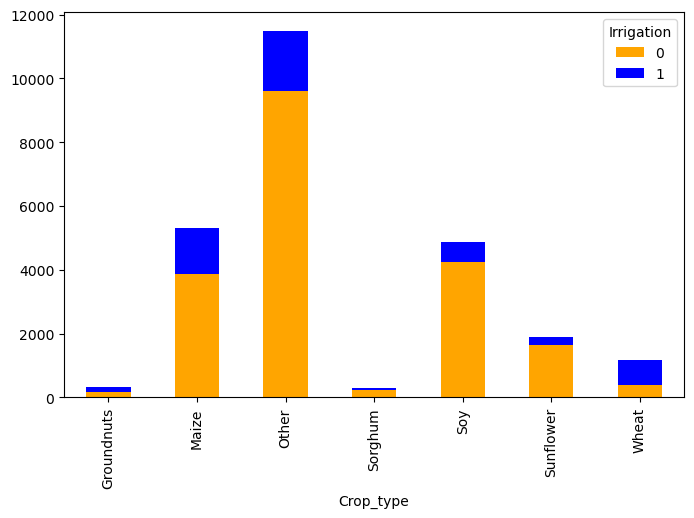

In [10]:
# plot histogram of Irrigation by Crop_type
df_group.groupby(['Crop_type', 'Irrigation']).size().unstack().plot(
    kind='bar',
    stacked=True,
    color=['orange', 'blue'],  # 0 = orange (Rainfed), 1 = blue (Irrigated)
    figsize=(8, 5)
)

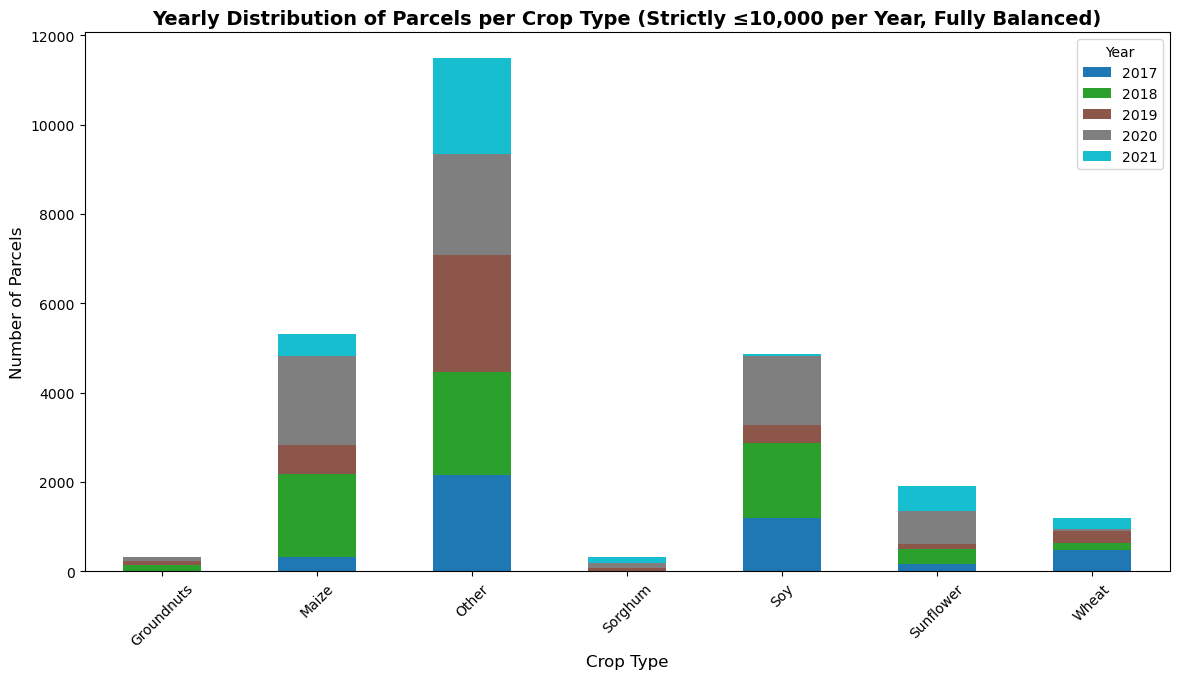

In [11]:
# Verify new unique FIELDID counts per crop and year
crop_year_counts_balanced = df_group.groupby(["Crop_type", "Year"]).size().unstack()


# Plot the balanced distribution
fig, ax = plt.subplots(figsize=(14, 7))

crop_year_counts_balanced.plot(kind="bar", stacked=True, cmap=cm.get_cmap("tab10"), ax=ax)

ax.set_title("Yearly Distribution of Parcels per Crop Type (Strictly ≤10,000 per Year, Fully Balanced)", fontsize=14, fontweight="bold")
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.legend(title="Year")

plt.xticks(rotation=45)
plt.show()

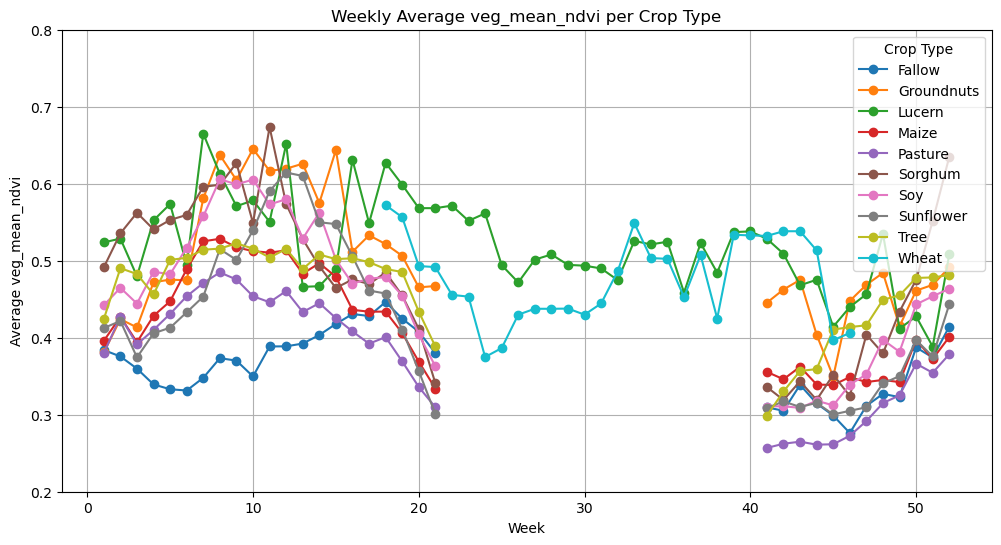

In [12]:
# Ensure 'week' and 'veg_mean_ndvi' are numeric
df.loc[:, "week"] = pd.to_numeric(df["week"], errors="coerce")
df.loc[:, "veg_mean_ndvi"] = pd.to_numeric(df["veg_mean_ndvi"], errors="coerce")


# Compute average veg_mean_ndvi per crop type per week
avg_ndvi_per_crop = df.groupby(["Crop_type", "week"], as_index=False)["veg_mean_ndvi"].mean()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each crop type's average NDVI time series
gap_threshold = 2  # max allowed week gap to keep the line

for crop in avg_ndvi_per_crop["Crop_type"].unique():
    subset = avg_ndvi_per_crop[avg_ndvi_per_crop["Crop_type"] == crop].sort_values("week")
    weeks = subset["week"].values
    ndvi_values = subset["veg_mean_ndvi"].values

    # Insert NaN where the gap is larger than threshold
    new_weeks = []
    new_ndvi = []
    for i in range(len(weeks)):
        new_weeks.append(weeks[i])
        new_ndvi.append(ndvi_values[i])
        if i < len(weeks) - 1 and (weeks[i+1] - weeks[i]) > gap_threshold:
            new_weeks.append(np.nan)
            new_ndvi.append(np.nan)

    plt.plot(new_weeks, new_ndvi, marker="o", linestyle="-", label=crop)

# Customize the plot
plt.xlabel("Week")
plt.ylabel("Average veg_mean_ndvi")
plt.title("Weekly Average veg_mean_ndvi per Crop Type")
plt.legend(title="Crop Type")
plt.grid(True)
plt.ylim(0.2, 0.8)

# Show the plot
plt.show()

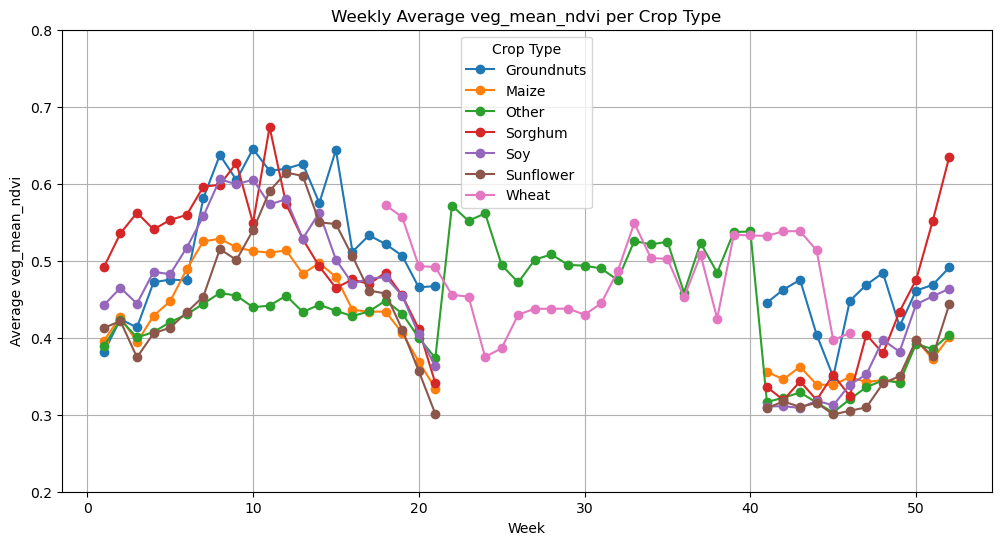

In [13]:
# Ensure 'week' and 'veg_mean_ndvi' are numeric
df_group.loc[:, "week"] = pd.to_numeric(df_group["week"], errors="coerce")
df_group.loc[:, "veg_mean_ndvi"] = pd.to_numeric(df_group["veg_mean_ndvi"], errors="coerce")


# Compute average veg_mean_ndvi per crop type per week
avg_ndvi_per_crop = df_group.groupby(["Crop_type", "week"], as_index=False)["veg_mean_ndvi"].mean()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each crop type's average NDVI time series
gap_threshold = 2  # max allowed week gap to keep the line

for crop in avg_ndvi_per_crop["Crop_type"].unique():
    subset = avg_ndvi_per_crop[avg_ndvi_per_crop["Crop_type"] == crop].sort_values("week")
    weeks = subset["week"].values
    ndvi_values = subset["veg_mean_ndvi"].values

    # Insert NaN where the gap is larger than threshold
    new_weeks = []
    new_ndvi = []
    for i in range(len(weeks)):
        new_weeks.append(weeks[i])
        new_ndvi.append(ndvi_values[i])
        if i < len(weeks) - 1 and (weeks[i+1] - weeks[i]) > gap_threshold:
            new_weeks.append(np.nan)
            new_ndvi.append(np.nan)

    plt.plot(new_weeks, new_ndvi, marker="o", linestyle="-", label=crop)

# Customize the plot
plt.xlabel("Week")
plt.ylabel("Average veg_mean_ndvi")
plt.title("Weekly Average veg_mean_ndvi per Crop Type")
plt.legend(title="Crop Type")
plt.grid(True)
plt.ylim(0.2, 0.8)

# Show the plot
plt.show()

In [14]:
# Save df_limited to a new CSV file
out_path = 'InputModel'
# use boosting factor in the output filename
output_filename = os.path.join(out_path, f'{dataset_name}{reduction_method}_group.csv')
df_group.to_csv(output_filename, index=False)
